### Importing libraries

In [121]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
import re
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import ADASYN

### Importing the dataset

In [122]:
path ='/kaggle/input/astronomical-data/cleaned_star_data.csv'
df = pd.read_csv(path)
df = pd.DataFrame(df)
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3042,0.0005,0.1542,16.6,0.0,Red,M
2,2600,0.0003,0.102,18.7,0.0,Red,M
3,2800,0.0002,,16.65,0.0,Red,M
4,1939,0.000138,0.103,20.06,0.0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830,1356,-9.93,5.0,Blue,O
236,30839,834042,1194,-10.63,5.0,Blue,O
237,8829,537493,1423,-10.73,5.0,White,A
238,9235,404940,1112,-11.23,5.0,White,A


### Data exploration

In [123]:
#converting columns "Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)", "Star type" into numeric format
df[["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)", "Star type"]] = \
df[["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)", "Star type"]].apply(pd.to_numeric, errors='coerce')
df["Star color"] = pd.Categorical(df["Star color"])
df["Spectral Class"] = pd.Categorical(df["Spectral Class"])

#replacing empty cells for columns "Star color" and "Spectral Class" with NaN
df["Star color"] = df["Star color"].replace("\s", np.nan, regex=True)
df["Spectral Class"] = df["Spectral Class"].replace("\s", np.nan, regex=True)

#inspecting the dimension of the dataset
shape = df.shape
print(f"There are {shape[0]} rows by {shape[1]} columns.")

#checking for duplicated rows in the dataset
dupes = df.duplicated().sum()
if dupes == 0:
    print("There are no duplicated rows in the dataset.")
else:
    print(f"There are {dupes} duplicated rows in the dataset")

print("The number of empty cells are listed below per feature.")

#checking the null values for each column
nulls = df.isnull().sum()
print(nulls)


There are 240 rows by 7 columns.
There are no duplicated rows in the dataset.
The number of empty cells are listed below per feature.
Temperature (K)           3
Luminosity(L/Lo)          7
Radius(R/Ro)              8
Absolute magnitude(Mv)    6
Star type                 1
Star color                7
Spectral Class            3
dtype: int64


### Data preprocessing

#### Predictor variables

In [124]:
mean_temp = df["Temperature (K)"].mean() #gets the mean from the temperature values
df["Temperature (K)"] = df["Temperature (K)"].fillna(mean_temp) #filling the empty temperature cells with the mean temperature

mean_lum = df["Luminosity(L/Lo)"].mean() #gets the mean from the luminosity values
df["Luminosity(L/Lo)"] = df["Luminosity(L/Lo)"].fillna(mean_lum) #filling the empty luminosity cells with the mean luminosity

mean_mv = df["Absolute magnitude(Mv)"].mean() #gets the mean from the absolute magnitude values
df["Absolute magnitude(Mv)"] = df["Absolute magnitude(Mv)"].fillna(mean_mv) #filling the empty absolute magnitude cells with the mean absolute magnitude

mean_rad = df["Radius(R/Ro)"].mean() #gets the mean from the Radius values
df["Radius(R/Ro)"] = df["Radius(R/Ro)"].fillna(mean_rad) #filling the empty Radius cells with the mean Radius

#### Spectral class

In [125]:
df = df.dropna(subset=["Spectral Class"]) #drops the the rows with empty values in the spectral class column

# ordinal encoding for spectral class feature 
df["Spectral Class"] = df["Spectral Class"].replace({
    "M": 0,
    "K": 1,
    "G": 2,
    "F": 3,
    "A": 4,
    "B": 5,
    "O": 6,
})
df["Spectral Class"] = pd.to_numeric(df["Spectral Class"])

df #prints the df to checks and see if the spectral class is converted from categorical to numerical values

/tmp/ipykernel_30/3226806235.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Spectral Class"] = df["Spectral Class"].replace({
/tmp/ipykernel_30/3226806235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Spectral Class"] = df["Spectral Class"].replace({
/tmp/ipykernel_30/3226806235.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
1,3042.0,0.000500,0.154200,16.60,0.0,Red,0
2,2600.0,0.000300,0.102000,18.70,0.0,Red,0
3,2800.0,0.000200,238.393907,16.65,0.0,Red,0
4,1939.0,0.000138,0.103000,20.06,0.0,Red,0
5,2840.0,107266.981895,0.110000,16.98,0.0,Red,0
...,...,...,...,...,...,...,...
235,38940.0,374830.000000,1356.000000,-9.93,5.0,Blue,6
236,30839.0,834042.000000,1194.000000,-10.63,5.0,Blue,6
237,8829.0,537493.000000,1423.000000,-10.73,5.0,White,4
238,9235.0,404940.000000,1112.000000,-11.23,5.0,White,4


#### Star color

In [126]:
df["Star color"] = df["Star color"].replace("\s", np.nan, regex=True) #replacing empty values (white spaces) in cells with NaN

features = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'] #assigning features for imputing the star color missing values

df_missing = df[df["Star color"].isnull()] #creates a dataset for the rows with missing star color values
df_not_missing = df[df["Star color"].notnull()] #creates a dataset for the rows with present star color values

df_not_missing["Star color"] = pd.Categorical(df_not_missing["Star color"]).codes 

#knn imputer for predicting the star color values 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df_not_missing[features], df_not_missing["Star color"])

df_missing["Star color"] = knn.predict(df_missing[features])

df['Star color'] = pd.Categorical(df['Star color'])
df['Star color'] = pd.Categorical(df['Star color'], categories=pd.Categorical(df_not_missing['Star color']).categories)

dfn = pd.concat([df_not_missing, df_missing]).sort_index()

df = pd.DataFrame(dfn)
df

/tmp/ipykernel_30/1367713166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Star color"] = df["Star color"].replace("\s", np.nan, regex=True) #replacing empty values (white spaces) in cells with NaN
/tmp/ipykernel_30/1367713166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_missing["Star color"] = pd.Categorical(df_not_missing["Star color"]).codes
/tmp/ipykernel_30/1367713166.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
1,3042.0,0.000500,0.154200,16.60,0.0,3,0
2,2600.0,0.000300,0.102000,18.70,0.0,3,0
3,2800.0,0.000200,238.393907,16.65,0.0,3,0
4,1939.0,0.000138,0.103000,20.06,0.0,3,0
5,2840.0,107266.981895,0.110000,16.98,0.0,3,0
...,...,...,...,...,...,...,...
235,38940.0,374830.000000,1356.000000,-9.93,5.0,1,6
236,30839.0,834042.000000,1194.000000,-10.63,5.0,1,6
237,8829.0,537493.000000,1423.000000,-10.73,5.0,4,4
238,9235.0,404940.000000,1112.000000,-11.23,5.0,4,4


### Checking assumptions

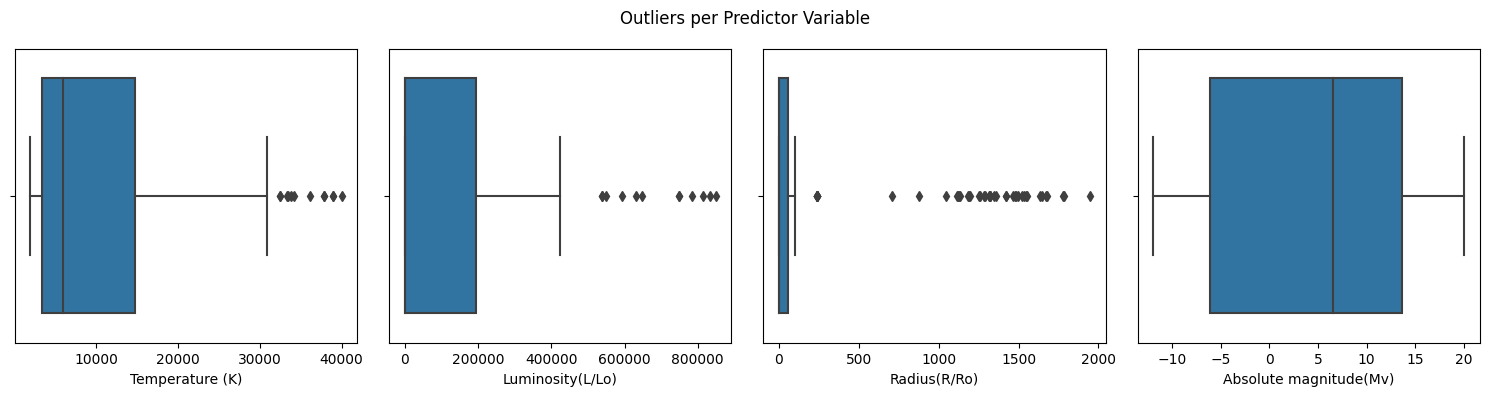

In [127]:
#box plot for checking outliers
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
sns.boxplot(x=df["Temperature (K)"])

plt.subplot(1,4,2)
sns.boxplot(x=df["Luminosity(L/Lo)"])

plt.subplot(1,4,3)
sns.boxplot(x=df["Radius(R/Ro)"])

plt.subplot(1,4,4)
sns.boxplot(x=df["Absolute magnitude(Mv)"])

plt.suptitle("Outliers per Predictor Variable")
plt.tight_layout()
plt.show()

Spectral Class
0    109
5     46
6     39
4     19
3     17
1      6
2      1
Name: count, dtype: int64


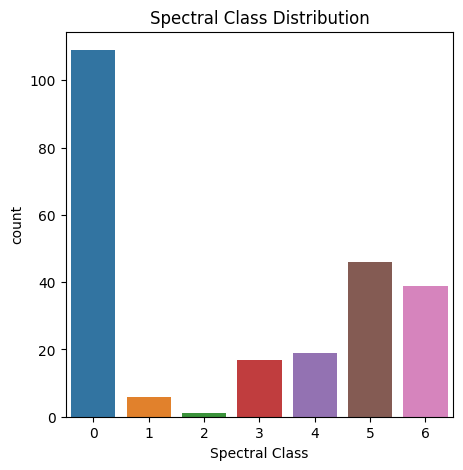

In [128]:
#checking class imbalance
class_distribution = df["Spectral Class"].value_counts()
print(class_distribution)

plt.figure(figsize=(5,5))
sns.countplot(x=df["Spectral Class"], data=df)
plt.title("Spectral Class Distribution")
plt.show()

In [129]:
#outlier transformation for temperature, luminosity, and radius
#absolute magnitude is not included since the feature doesn't have any outliers
df['temperature_log'] = np.log1p(df["Temperature (K)"])
df['luminosity_log'] = np.log1p(df["Luminosity(L/Lo)"])
df['radius_log'] = np.log1p(df["Radius(R/Ro)"])

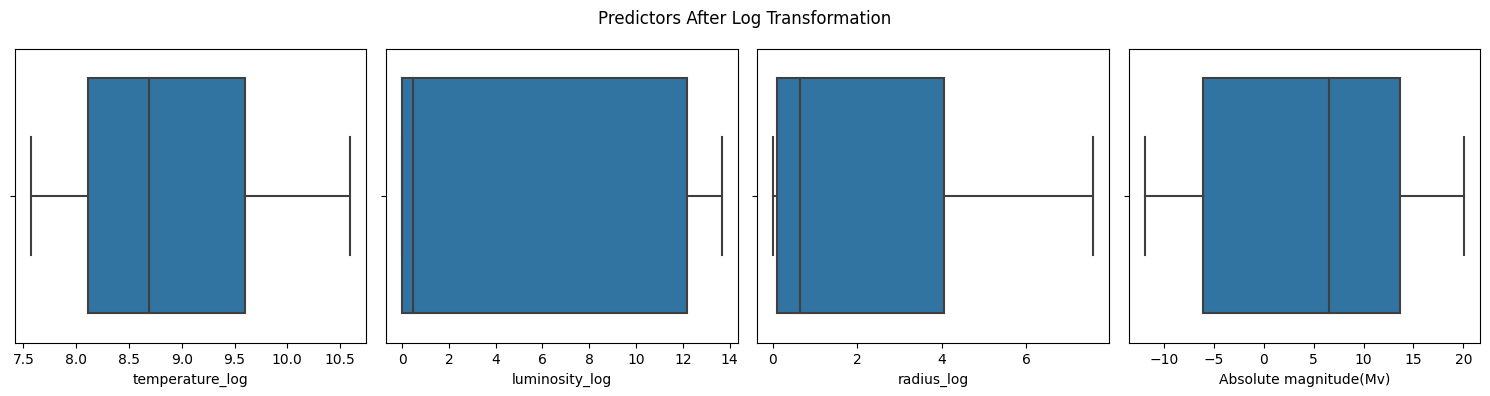

In [130]:
plt.figure(figsize=(15, 4))

plt.subplot(1,4,1)
sns.boxplot(x=df["temperature_log"])

plt.subplot(1,4,2)
sns.boxplot(x=df["luminosity_log"])

plt.subplot(1,4,3)
sns.boxplot(x=df["radius_log"])

plt.subplot(1,4,4)
sns.boxplot(x=df["Absolute magnitude(Mv)"])

plt.suptitle("Predictors After Log Transformation")
plt.tight_layout()
plt.show()

### Data modeling

In [131]:
#define x and y features
x_features = df[['temperature_log', 'luminosity_log', 'radius_log', 'Absolute magnitude(Mv)']]
y_features = df["Spectral Class"]

#split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_features, y_features, test_size=0.2, random_state=42)

In [132]:
model = KNeighborsClassifier(n_neighbors=5, weights='distance') #initialize KNN classifier as model with weighted distances
model.fit(x_train, y_train) #fit training sets into the model

y_pred = model.predict(x_test) #predict y_pred by using the model on x_test values 

### Model assessment

In [133]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"The model's accuracy: {accuracy:.2f}\n")
print(report)

The model's accuracy: 0.81

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       0.00      0.00      0.00         2
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         4
           5       0.73      0.89      0.80         9
           6       0.67      1.00      0.80         4

    accuracy                           0.81        48
   macro avg       0.47      0.54      0.49        48
weighted avg       0.71      0.81      0.75        48



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


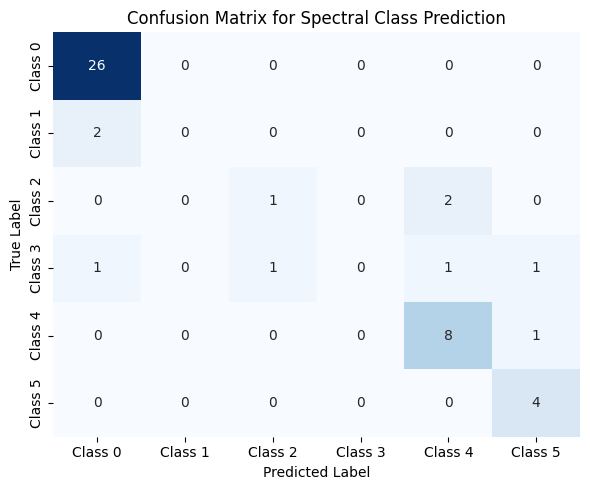

In [134]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])

plt.title('Confusion Matrix for Spectral Class Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### Data augmentation